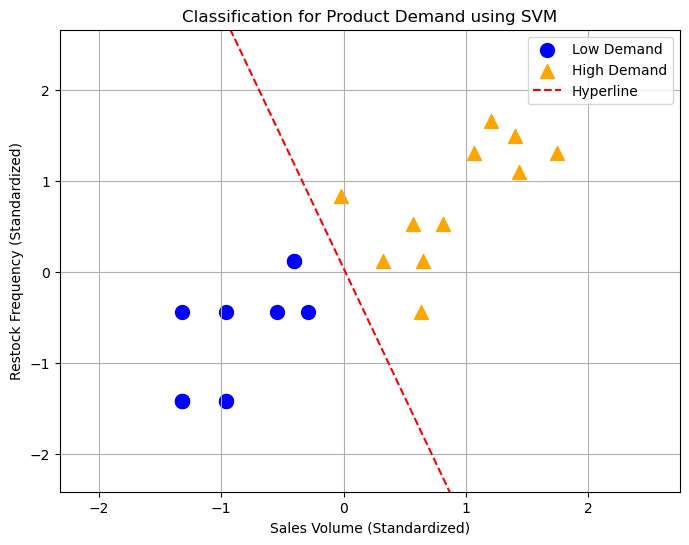

High Demand:
1. Colgate Maximum Cavity Protection Toothpaste 225G x 2's
2. Colgate Optic White Toothpaste 100g
3. Colgate Sensitive Pro Relief Toothpaste (110g/114g)
4. Colgate Triple Action Original Mint 175g (Value Pack of 2)
5. Daia Smart Concentrated Liquid Detergent Refill 1.7kg
6. Daia Softener Refill 900ml
7. Daia Softener Refill Pack 1.8L/1.6L
8. Daia Washing Power Powder [2.2KG / 2.3KG/2.4KG]
9. Garbage Bag Plastik Sampah Size S/M/L/XL
10. Softlan Fabric Softener Refill Pack 1.4L
11. Tracia Lightening Goat Milk / Shea Butter Shower Cream 1000ml

Low Demand:
1. Colgate Plax Mouthwash Valuepack 750ml x 2
2. Dettol Hand Wash (250ml) - Skincare
3. Dettol Hand Wash Skincare Pouch (225ml) Dettol Sakura Refill
4. F&N Sweetened & Condensed Filled Milk (500g)
5. Garnier Color Naturals Ultra Color Hair Dye Colour 30g
6. Life Tomato Sauce 485g
7. Mee Sedap Asli / Mi Sedaap Perisa Asli (5PCS x 90G)
8. OPP Tape Transparent 48mm x 80y Premium Grade
9. Quaker Oats - Whole Rolled Oats 800g
10

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Load the data from the CSV file
file_path = '22_product_quantities_random_restock_limited_no_stock.csv'  # Replace with your file path
product_data = pd.read_csv(file_path)

# Calculate Sales Volume and Restock Frequency for each product
sales_volumes = []
restock_frequencies = []

for _, row in product_data.iterrows():
    daily_changes = pd.to_numeric(row[1:].diff(), errors='coerce').fillna(0)
    sales_volume = -daily_changes[daily_changes < 0].sum()
    restock_frequency = (daily_changes > 0).sum()
    sales_volumes.append(sales_volume)
    restock_frequencies.append(restock_frequency)

# Add Sales Volume and Restock Frequency to the DataFrame
product_data['Sales_Volume'] = sales_volumes
product_data['Restock_Frequency'] = restock_frequencies

# Apply logarithmic transformation to spread out the data points
product_data['Log_Sales_Volume'] = np.log1p(product_data['Sales_Volume'])  # log1p to handle zero values
product_data['Log_Restock_Frequency'] = np.log1p(product_data['Restock_Frequency'])

# Prepare the transformed data for SVM
X = product_data[['Log_Sales_Volume', 'Log_Restock_Frequency']].values

# Standardize the log-transformed data to achieve balanced spread of points
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Assign labels based on a threshold for Sales Volume (e.g., median)
threshold = np.median(sales_volumes)
y = np.array([1 if volume > threshold else 0 for volume in sales_volumes])  # 1 for high demand, 0 for low demand

# Train an SVM model on the transformed and standardized data
svm_model = SVC(kernel='linear')
svm_model.fit(X_standardized, y)

# Plotting the data points and decision boundary
plt.figure(figsize=(8, 6))

# Plot data points for High Demand and Low Demand with specific colors and markers
plt.scatter(X_standardized[y == 0][:, 0], X_standardized[y == 0][:, 1], color='blue', s=100, marker='o', label="Low Demand")
plt.scatter(X_standardized[y == 1][:, 0], X_standardized[y == 1][:, 1], color='orange', s=100, marker='^', label="High Demand")

# Plot decision boundary (hyperline)
w = svm_model.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(X_standardized[:, 0].min() - 1, X_standardized[:, 0].max() + 1)
yy = a * xx - (svm_model.intercept_[0]) / w[1]
plt.plot(xx, yy, 'r--', label="Hyperline")

# Adding an arrow annotation for the hyperline
plt.annotate('Hyperline', xy=(xx[10], yy[10]), xytext=(xx[10] - 1.5, yy[10] + 1.5),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# Adjust axis limits for similar spacing and better separation of Low Demand
plt.xlim(X_standardized[:, 0].min() - 1, X_standardized[:, 0].max() + 1)
plt.ylim(X_standardized[:, 1].min() - 1, X_standardized[:, 1].max() + 1)

# Adding labels and legend
plt.xlabel("Sales Volume (Standardized)")
plt.ylabel("Restock Frequency (Standardized)")
plt.title("Classification for Product Demand using SVM")
plt.legend()
plt.grid(True)
plt.show()

# Predict the demand classification for each product
y_pred = svm_model.predict(X_standardized)
product_data['Demand_Classification'] = y_pred

# Output classified products after displaying the plot
print("High Demand:")
for i, product in enumerate(product_data[product_data['Demand_Classification'] == 1]['Product'], start=1):
    print(f"{i}. {product}")

print("\nLow Demand:")
for i, product in enumerate(product_data[product_data['Demand_Classification'] == 0]['Product'], start=1):
    print(f"{i}. {product}")
